### Data Wrangling with MongoDB: OpenStreetMap Project
*by Gisle JT Gaasemyr*

The primary goal of this analysis is to determine the quality of OpenStreetMap address data in the Bergen, Norway region. The main focus will be on postcode accuracy and duplicate discovery. It is not within the scope of this project to correct any errors, but rather to point out discovered errors and areas which should be investigated further.

Before performing the analysis below, I cleaned the downloaded data file in preparation for mongodb import. I corrected incorrect postcodes and streetnames, using official government resources for quality control. For complete information about this process, see the notebook osm_data_wrangling.ipynb (html version: osm_data_wrangling.html).

In [1]:
#importing classes from display and pretty print modules
from pprint import pprint
from IPython.display import HTML
from IPython.display import display
#importing other necessary modules and packages
import pandas as pd
from collections import defaultdict
from pymongo import MongoClient
from operator import itemgetter
import difflib
from fuzzywuzzy import fuzz
from matplotlib import pyplot as plt
import seaborn as sns

#For convenience imports are also included in individual cells where relevant

In [2]:
#Setting up MongoDB connection
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017")
db = client.osm
#Creating db.bergen as a variable for the sake of brevity
bergen = db.bergen

In [3]:
#Getting an initial overview of the data
display(HTML('<b>Count of documents in database:</b>'),bergen.count())
display(HTML('<b>First record:</b>'))
pprint(bergen.find_one())
display(HTML('<b>Document Types:</b>'))

pipeline = [ 
    { '$group': {'_id': '$type', 'count': { '$sum': 1 } } },
    {'$sort': {'count': -1 } }
]

for res in bergen.aggregate(pipeline):
    print(res['_id'],res['count'])

681172

{'_id': ObjectId('590efcae49fce35f8f53030a'),
 'created': {'changeset': '6007582',
             'timestamp': '2010-10-10T22:30:34Z',
             'uid': '114230',
             'user': 'danerikk',
             'version': '2'},
 'id': '358065',
 'pos': [60.5320227, 5.2557628],
 'type': 'node'}


node 628779
way 52393


In [86]:
#Ensuring no other type records, due to previous import error
bergen.find_one( {'type': {'$nin': ['way','node']} })

In [4]:
#Creating indexes

from pymongo import ASCENDING

bergen.create_index([('address', ASCENDING),('address.street', ASCENDING),('address.housenumber', ASCENDING)])


'address_1_address.street_1_address.housenumber_1'

In [5]:
#Getting count of documents with address field

address_query = { 'address' : {'$exists' : True }}
address_documents = bergen.find(address_query)
address_count = address_documents.count()

display(HTML('<b>Number of addresses in dataset:</b>'),address_count)


84625

In [6]:
#Getting counts for streetnames and addresses

aggregated = bergen.aggregate([  
        {'$match' : {'address': {'$exists' : True } } },
        { "$group" : { 
                "_id" : "$address.street","count" : { "$sum" : 1} } }
    ])

household_count = 0
unique_street_count = 0
addresses_on_street = {}

for doc in aggregated:
    household_count += doc['count']
    unique_street_count += 1
    
    addresses_on_street[doc['_id']] = doc['count']

print("total addresses in Bergen:", household_count)
print("number of streetnames:", unique_street_count)

total addresses in Bergen: 84625
number of streetnames: 2231


According to January 2016 data from Statistics Norway (SSB), there are 134,328 households in Bergen. The data used by Statistics Norway is collected from the National Registry, and the data includes unit numbers for a minimum 95% of the addresses where such a number exists. The available OSM data does not contain unit numbers. Several addresses in Bergen contain multiple home units, and although the OSM data also contains non-household addresses (businesses, public institutions etc.) the number of addresses in the OSM data seems reasonable.

Next I will take a look at the streets with the most addresses on them, to see if any of the top 10 streets are surprising, and if any of the streets have a surprisingly high number of addresses.

In [7]:
#Taking a look at the streets with the most addresses

from operator import itemgetter

streetnames_sorted_dict = dict(sorted(addresses_on_street.items(), key=lambda x: x[1], reverse=True)[:10])
streetnames_sorted_list = sorted(addresses_on_street.items(), key=lambda x: x[1], reverse=True)


display(HTML("<b>Streets with most addresses on them:</b>"))

for street,count in streetnames_sorted_list[0:10]:
    print(street,count)

Myrdalskogen 442
Askvegen 397
Søråshøgda 377
Kringlebotn 304
Flaktveitvegen 293
Stongafjellsvegen 289
Hjellestadvegen 277
Hetlevikåsen 276
Langarinden 273
Nipedalen 250


Based on my local knowledge of the area, the list above is not very surprising. None of the streets have a higher number of addresses than I expected.

In [8]:
#Ensuring corrected street names in cleaning script are in fact corrected in the database
for street,count in streetnames_sorted_list:
    
    if street is None:
        pass
    
    elif ('Thormøhlens' or 'Smøråshøgda 9' or 'Laguneveien 1' or 'Gate' or '.' or 'Tokanten') in street:
        #expecting 1 result
        print(street,count)

Thormøhlens gate 47


In [9]:
#Ensuring all postcodes starting with 'NO-' are corrected. Expecting 0 results from query.
for doc in bergen.find( {'address.postcode': {'$regex': 'NO.*'} } ):
    pprint(doc['address'])
    print('----------')

### Misspelled street names

In [10]:
#Checking for potential duplicate data due to misspelled street names

import difflib
from fuzzywuzzy import fuzz

def fuzzy_streets(ratio,house_count):
    
    fuzzy_matches = list()
    compare_count = 0
    
    for k1 in streetnames_sorted_list:

        if k1[0] is None:
            print("Addresses without street name:",k1[1])

        #Only comparing street names with less addresses than house_count
        elif k1[1] <= house_count:
            
            compare_count += 1

            for k2 in streetnames_sorted_list:

                if k2[0] is None:
                    pass

                elif k2[0] == k1[0]:
                    pass

                else:                    
                    
                    fuzz_ratio = fuzz.ratio(k1[0],k2[0])
                    
                    if fuzz_ratio >= ratio:
                        fuzzy_matches.append({k1: k2,"fuzz ratio": fuzz_ratio})

    print("Number of street names compared: {0} of {1}".format(compare_count,len(streetnames_sorted_list)))
    
    return fuzzy_matches

In [11]:
#Lower than 90 fuzzy ratio gives too many false positives. Same goes for higher than 10 addresses on the street.
potential_misspellings = fuzzy_streets(92,10)

Addresses without street name: 184
Number of street names compared: 526 of 2231


In [12]:
potential_misspellings

[{('Dreggsallmenningen', 10): ('Dreggsallmenning', 1), 'fuzz ratio': 94},
 {'fuzz ratio': 94, ('Herman Foss’ gate', 9): ("Herman Foss' gate", 1)},
 {'fuzz ratio': 95,
  ('Vilhelm Bjerknesvei', 9): ('Vilhelm Bjerknes’ vei', 111)},
 {'fuzz ratio': 92, ('Flyplassveien', 7): ('Flyplassvegen', 27)},
 {'fuzz ratio': 92, ('Solhaugveien', 7): ('Solhaugvegen', 22)},
 {'fuzz ratio': 98,
  ('Haakon Sheteligs plass', 6): ('Haakon Shetelings plass', 2)},
 {'fuzz ratio': 95, ('Austevågen', 5): ('Austrevågen', 21)},
 {'fuzz ratio': 92, ('Vestre Mulelvsmauet', 4): ('Østre Mulelvsmauet', 3)},
 {'fuzz ratio': 92, ('Travparkvegen', 3): ('Travparkveien', 1)},
 {'fuzz ratio': 92, ('Østre Mulelvsmauet', 3): ('Vestre Mulelvsmauet', 4)},
 {'fuzz ratio': 92, ('Nesttunveien', 3): ('Nesttunvegen', 59)},
 {'fuzz ratio': 97, ('Torgalmenningen', 2): ('Torgallmenningen', 29)},
 {'fuzz ratio': 98,
  ('Haakon Shetelings plass', 2): ('Haakon Sheteligs plass', 6)},
 {'fuzz ratio': 92, ('C.Sundtsgate', 2): ('C. Sundts ga

In [13]:
#Printing out the potential misspellings
import pandas as pd

df_potential_misspellings = pd.DataFrame(columns = [
        'high_spelling','high_count','low_spelling','low_count','fuzz_ratio'])

#Adding index to make it easier to sort out the items I need to investigate further
count = 0

for spellings in potential_misspellings:
    count += 1
    df_potential_misspellings.loc[count] = None
    for key, val in spellings.items():
        if type(key) == tuple:
            if key[1] > val[1]:
                df_potential_misspellings.loc[count]['high_spelling'] = key[0]
                df_potential_misspellings.loc[count]['low_spelling'] = val[0]
                df_potential_misspellings.loc[count]['high_count'] = key[1]
                df_potential_misspellings.loc[count]['low_count'] = val[1]

            else:
                df_potential_misspellings.loc[count]['high_spelling'] = val[0]
                df_potential_misspellings.loc[count]['low_spelling'] = key[0]
                df_potential_misspellings.loc[count]['high_count'] = val[1]
                df_potential_misspellings.loc[count]['low_count'] = key[1]
        else:
            df_potential_misspellings.loc[count]['fuzz_ratio'] = val

df_potential_misspellings.drop_duplicates().sort_values('high_spelling',ascending=True)

,high_spelling,high_count,low_spelling,low_count,fuzz_ratio
7,Austrevågen,21,Austevågen,5,95
25,Bønesskogen,222,Børnesskogen,1,96
14,C. Sundts gate,53,C.Sundtsgate,2,92
1,Dreggsallmenningen,10,Dreggsallmenning,1,94
24,Espelandsvegen,76,Espelandsveien,1,93
4,Flyplassvegen,27,Flyplassveien,7,92
6,Haakon Sheteligs plass,6,Haakon Shetelings plass,2,98
15,Hallvardsvegen,14,Halvardsvegen,1,96
2,Herman Foss’ gate,9,Herman Foss' gate,1,94
20,Lars Hilles gate,26,Lars Hillesgate,1,97


In [14]:
df_misspelled_streets = df_potential_misspellings.loc[[18,13,1,19,6,17,2,22,9,15,12,23,10,16,3]]
df_misspelled_streets.rename(columns={ 
    'high_spelling': 'correct_name', 'low_spelling': 'wrong_name' }, inplace=True )
df_correct_spellings = df_potential_misspellings.loc[8]
df_spellings_require_research = df_potential_misspellings.loc[[4,7,5,20]]

df_misspelled_streets[['correct_name','wrong_name']].to_csv(
    'data/misspelled_streets.csv',index=False)
df_spellings_require_research.to_csv('data/research_streets_spelling.csv',index=False)

In [15]:
df_misspelled_streets

,correct_name,high_count,wrong_name,low_count,fuzz_ratio
18,Vestre Murallmenningen,27,Vestre murallmenningen,1,95
13,Haakon Sheteligs plass,6,Haakon Shetelings plass,2,98
1,Dreggsallmenningen,10,Dreggsallmenning,1,94
19,Travparkvegen,3,Travparkveien,1,92
6,Haakon Sheteligs plass,6,Haakon Shetelings plass,2,98
17,Søråshøgda,377,Smøråshøgda,1,95
2,Herman Foss’ gate,9,Herman Foss' gate,1,94
22,Herman Foss’ gate,9,Herman Foss' gate,1,94
9,Travparkvegen,3,Travparkveien,1,92
15,Hallvardsvegen,14,Halvardsvegen,1,96


In [16]:
#Getting counts from db again 
for inx,name in df_misspelled_streets.iterrows():
    print(name[2],bergen.find( { 'address.street': name[2]}).count() )

Vestre murallmenningen 1
Haakon Shetelings plass 2
Dreggsallmenning 1
Travparkveien 1
Haakon Shetelings plass 2
Smøråshøgda 1
Herman Foss' gate 1
Herman Foss' gate 1
Travparkveien 1
Halvardsvegen 1
Torgalmenningen 2
Totlandsveien 1
Østre Mulelvsmauet 3
Dreggsallmenning 1
Vilhelm Bjerknesvei 9


In [17]:
#Updating records
for inx,name in df_misspelled_streets.iterrows():
    bergen.update_many( { 'address.street': name[2]},
                  { '$set': {'address.street': name[0] } 
                  } )

In [18]:
#Ensuring all is corrected. All should return count 0
for inx,name in df_misspelled_streets.iterrows():
    print(name[2],bergen.find( { 'address.street': name[2]}).count() )

Vestre murallmenningen 0
Haakon Shetelings plass 0
Dreggsallmenning 0
Travparkveien 0
Haakon Shetelings plass 0
Smøråshøgda 0
Herman Foss' gate 0
Herman Foss' gate 0
Travparkveien 0
Halvardsvegen 0
Torgalmenningen 0
Totlandsveien 0
Østre Mulelvsmauet 0
Dreggsallmenning 0
Vilhelm Bjerknesvei 0


Above I have performed some QA on the street names from the Bergen OSM dataset. I have taken a closer look at the street names with less than 10 house numbers, and I have compared those street with the other street names to spot potential misspelled and duplicate street names. Based on lingual and local knowledge, I have sorted the potential misspelled streetnames into three categories: actual misspelled names, correctly spelled names and names which require more research. All 3 categories are imported to csv files, and I have corrected the actual misspelled names in the database.

### Duplicate addresses

In [19]:
#Finding duplicate addresses

pipeline = [
    { '$group': { 
            '_id': { 'street': '$address.street', 'housenumber': '$address.housenumber' }, 
                'postcodes': { '$addToSet': '$address.postcode' }, 
            'count': {'$sum': 1 }
            }
        },
    { '$match': {'count': {'$gt': 1} } },
    {'$sort' : {'count' : -1} } ]


duplicate_addresses = []
duplicate_addresses_count = 0

for doc in bergen.aggregate(pipeline):
    duplicate_addresses.append(doc)
    if doc['_id'] != {}:
        duplicate_addresses_count += doc['count']

print("Number of potential duplicate addresses:", len(duplicate_addresses))
print("Documents with potential duplicate addresses:", duplicate_addresses_count)

Number of potential duplicate addresses: 913
Documents with potential duplicate addresses: 2104


In [21]:
#Converting result of duplicate address query to Pandas dataframe for easier view

from pandas.io.json import json_normalize

df_duplicate_addresses = json_normalize(duplicate_addresses)

#Changing column names
df_duplicate_addresses.rename(columns={'_id.housenumber': 'housenumber','_id.street':'street'},inplace=True)
#Changing column order
df_duplicate_addresses = df_duplicate_addresses[['street', 'housenumber', 'count', 'postcodes']]

df_duplicate_addresses.head(7)

,street,housenumber,count,postcodes
0,NaN,NaN,596731,"[5021, 5835, 5281, 5116, 5918]"
1,Kanalveien,66,13,[5068]
2,Lyngmarka,NaN,12,[5302]
3,Valkendorfsgaten,6,12,[5012]
4,Kalfarveien,37,11,[5022]
5,Kanalveien,64,10,[5068]
6,Sandslihaugen,10,10,[5254]


In [24]:
#Getting some information about duplicate addresses with different postcodes

df_different_postcodes = df_duplicate_addresses[df_duplicate_addresses['postcodes'].apply(lambda x: len(x) > 1)]

# Adding column for count of postcodes for the address
df_different_postcodes = df_different_postcodes.assign(postcode_count=df_different_postcodes['postcodes'].str.len())

print('Number of duplicate addresses with different postcodes:',len(df_different_postcodes) )
print('Duplicate addresses where all the duplicates have unique postcodes:',len(
    df_different_postcodes[df_different_postcodes['count'] == df_different_postcodes['postcode_count']]))

df_different_postcodes.sort_values('postcode_count', ascending=False).head(7)

Number of duplicate addresses with different postcodes: 252
Duplicate addresses where all the duplicates have unique postcodes: 242


,street,housenumber,count,postcodes,postcode_count
0,NaN,NaN,596731,"[5021, 5835, 5281, 5116, 5918]",5
138,Liavegen,17,3,"[5307, 5132, 5378]",3
40,Liavegen,10,4,"[5307, 5132, 5378]",3
86,Haugane,4,3,"[5307, 5212, 5360]",3
137,Liavegen,12,3,"[5307, 5132, 5378]",3
673,Lynghaugen,4,2,"[5038, 5350]",2
669,Liavegen,4,2,"[5307, 5378]",2


242 of the 914 potential duplicate addresses are likely not true duplicates, as they have unique postcodes for the address.

In [25]:
#Function for printing individual address search results

def search_one_address(street, housenumber):
        
    query = { 'address.street': street, 'address.housenumber': {'$in': [str(housenumber),housenumber ] } }
        
    for doc in bergen.find(query):
        pprint(doc)

In [26]:
#Looking at all documents with the top duplicate address
search_one_address('Kanalveien','66')

{'_id': ObjectId('590efcce49fce35f8f5c251a'),
 'address': {'city': 'Bergen',
             'housenumber': '66',
             'postcode': '5068',
             'street': 'Kanalveien'},
 'created': {'changeset': '40278280',
             'timestamp': '2016-06-25T09:11:13Z',
             'uid': '1965308',
             'user': 'FredrikLindseth',
             'version': '1'},
 'id': '4264196717',
 'level': '2',
 'name': 'Bergen Bibelskole',
 'office': 'yes',
 'pos': [60.3621861, 5.3469652],
 'type': 'node'}
{'_id': ObjectId('590efcce49fce35f8f5c251c'),
 'address': {'city': 'Bergen',
             'housenumber': '66',
             'postcode': '5068',
             'street': 'Kanalveien'},
 'created': {'changeset': '40278280',
             'timestamp': '2016-06-25T09:11:13Z',
             'uid': '1965308',
             'user': 'FredrikLindseth',
             'version': '1'},
 'id': '4264196718',
 'level': '1',
 'name': 'Bergen Innredning og Montasje',
 'office': 'yes',
 'pos': [60.3620529, 5.34697

In [27]:
#Looking at one of the nodes

bergen.find_one({'id': '4264197029'})

{'_id': ObjectId('590efcce49fce35f8f5c25ee'),
 'created': {'changeset': '40278280',
  'timestamp': '2016-06-25T09:11:20Z',
  'uid': '1965308',
  'user': 'FredrikLindseth',
  'version': '1'},
 'id': '4264197029',
 'pos': [60.3620325, 5.3469011],
 'type': 'node'}

<img src="data/kanalveien_66_duplicates.png" align="right" width="250">

Looking up the address with the most duplicates (13), Kanalveien 66, on the OpenStreetMap.org website, it becomes apparent that at least part of the reason for the many duplicates is that there are multiple business located at that address, and each business seems to have gotten its own address. 

According to the [OSM wiki](http://wiki.openstreetmap.org/wiki/Addresses#How_to_map_addresses), the policy on duplicate addresses is unclear in such cases: "However, there is still some debate on that point (see for example Address information in POI *and* building? on help.openstreetmap.org). Also, the community in some countries has established their own rules."

In [28]:
#Function for checking individual addresses for duplicates

def duplicate_count(street,housenumber, return_list=False):
    display((HTML('<em>{0} {1}</em>'.format(street,housenumber) ) ) )
    query = { 'address.street': street, 'address.housenumber': {'$in': [str(housenumber),housenumber ] } }
    
    count = -1
    re_list = list()
    postcodes = defaultdict(int)
    
    for doc in bergen.find(query):
        count += 1
        postcodes[doc['address']['postcode']] += 1
        if return_list:
            re_list.append(doc)
    
    if count == -1:
        print("Address not found.")
    else:
        print("Duplicate records:", count)
        print("Postcodes:",dict(postcodes))
        if return_list:
            return re_list

In [55]:
bergen.find_one( {'address.street': 'Smøråshøgda'})

In [56]:
bergen.find_one( {'id': '334326937'})

{'_id': ObjectId('590efcd649fce35f8f5ce192'),
 'address': {'city': 'Rådal',
  'housenumber': 9,
  'postcode': '5235',
  'street': 'Søråshøgda'},
 'building': 'retail',
 'created': {'changeset': '29680703',
  'timestamp': '2015-03-23T14:58:32Z',
  'uid': '715936',
  'user': 'Gazer75',
  'version': '1'},
 'id': '334326937',
 'name': 'Kilden Senter',
 'node_refs': ['3414385236',
  '3414385217',
  '3414385201',
  '3414385189',
  '3414385186',
  '3414385188',
  '3414385190',
  '3414385192',
  '3414385209',
  '3414385212',
  '3414385214',
  '3414385220',
  '3414385223',
  '3414385236'],
 'shop': 'mall',
 'type': 'way',
 'website': 'http://kilden-senter.no/',
 'wheelchair': 'yes'}

In [29]:
'''
Checking for duplicates among the cleaned addresses which had housenumber \
as part of the address name in the pre-cleaned file. 
'''
duplicate_count('Laguneveien',1)
duplicate_count('Smøråshøgda',9)
duplicate_count('Steinsvikvegen',430)

#For Vilhelm Bjerknesvei checking both individual addresses and range housenumber
duplicate_count('Vilhelm Bjerknesvei','4-10')
for i in range(4,11):
    duplicate_count('Vilhelm Bjerknesvei',i)

Duplicate records: 4
Postcodes: {'5235': 1, '5239': 4}


Address not found.


Duplicate records: 0
Postcodes: {'5239': 1}


Address not found.


Address not found.


Address not found.


Address not found.


Address not found.


Address not found.


Address not found.


Address not found.


It is not very surprising that Vilhelm Bjerknesvei 4, 6, 7 8, 9 and 10 are missing, as they are probably among the documents which were imported with address Vilhelm Bjerknesvei 4-10. It is however surprising that there are no documents with address Vilhelm Bjerknesvei 4-10 and Smøråshøgda 9. Looking at the identified misspelled street names, I see why this is: they are both among the corrected street names. I will therefore run the queries again with the corrected spellings.

In [71]:
duplicate_count('Søråshøgda',9)
#For Vilhelm Bjerknes’ vei checking both individual addresses and range housenumber
duplicate_count("Vilhelm Bjerknes’ vei",'4-10')
for i in range(4,11):
    duplicate_count("Vilhelm Bjerknes’ vei",i)

Duplicate records: 1
Postcodes: {'5235': 2}


Duplicate records: 6
Postcodes: {'5081': 7}


Duplicate records: 0
Postcodes: {'5081': 1}


Address not found.


Address not found.


Address not found.


Address not found.


Address not found.


Duplicate records: 0
Postcodes: {'5081': 1}


There are seven documents with address Vilhelm Bjerknes’ vei 4-10, and 2 documents for the individual addresses in the 4-10 range (e.g. Vilhelm Bernesvei 7). While this is a data error, only 2 of the 7 documents with address Vilhelm Bjerknesvei 4-10 are likely to be true duplicates.

I will take a closer look at the duplicate Laguneveien 1 documents.

In [30]:
#Searching for duplicates of Laguneveien 1

search_one_address('Laguneveien',1)

{'_id': ObjectId('590efcb349fce35f8f54b419'),
 'address': {'city': 'Rådal',
             'housenumber': 1,
             'postcode': '5235',
             'street': 'Laguneveien'},
 'amenity': 'restaurant',
 'created': {'changeset': '39294271',
             'timestamp': '2016-05-13T14:59:10Z',
             'uid': '1965308',
             'user': 'FredrikLindseth',
             'version': '6'},
 'id': '1652908136',
 'name': 'Egon Lagunen',
 'outdoor_seating': 'yes',
 'pos': [60.2962144, 5.3301382],
 'type': 'node',
 'website': 'http://www.egon.no/',
 'wheelchair': 'yes'}
{'_id': ObjectId('590efcb649fce35f8f557852'),
 'address': {'city': 'Rådal',
             'housenumber': '1',
             'postcode': '5239',
             'street': 'Laguneveien'},
 'created': {'changeset': '26026343',
             'timestamp': '2014-10-12T14:10:49Z',
             'uid': '103253',
             'user': 'gormur',
             'version': '1'},
 'id': '3125931672',
 'pos': [60.2968652, 5.3311546],
 'type': 'no

In [31]:
pipeline = [
    { '$match': { 'address.street': 'Laguneveien' } },
    { '$group': { 
            '_id': '$address.postcode', 'count' : {'$sum': 1 } 
        } 
    },
    {'$sort' : {'count' : -1} }
    
]

for doc in bergen.aggregate(pipeline):
    pprint(doc)

{'_id': '5239', 'count': 19}
{'_id': '5235', 'count': 1}


In [32]:
query = { 'address.street': 'Laguneveien', 'address.postcode': '5235', 'address.housenumber': 1 }

for doc in bergen.find(query):
    pprint(doc)

{'_id': ObjectId('590efcb349fce35f8f54b419'),
 'address': {'city': 'Rådal',
             'housenumber': 1,
             'postcode': '5235',
             'street': 'Laguneveien'},
 'amenity': 'restaurant',
 'created': {'changeset': '39294271',
             'timestamp': '2016-05-13T14:59:10Z',
             'uid': '1965308',
             'user': 'FredrikLindseth',
             'version': '6'},
 'id': '1652908136',
 'name': 'Egon Lagunen',
 'outdoor_seating': 'yes',
 'pos': [60.2962144, 5.3301382],
 'type': 'node',
 'website': 'http://www.egon.no/',
 'wheelchair': 'yes'}


According to The Norwegian Mapping Authority, the correct postal code for Laguneveien is 5239. The postcode for the 5235 document is incorrect.

### Contributors

In [33]:
from collections import defaultdict

user_count_query = bergen.aggregate( [
   {
     '$group': {
        '_id' : { 'uid': '$created.uid', 'username': '$created.user' }
           }
        },
   {
     '$group': {
        '_id': 'null',
        'count': { '$sum': 1 }
     }
   }
] )

for doc in user_count_query:
    user_count = doc['count']

average_contributions = bergen.aggregate( [
   {
          '$group': 
            {
                '_id' : 
                { 'uid': '$created.uid', 'username': '$created.user' },
                'count': { '$sum': 1 } 
            } 
    },
    { 
            '$group': 
            {
                '_id': 'null',
                'avg': { '$avg': '$count' } 
            }
    }
] )

for doc in average_contributions:
    user_average = round(doc['avg'],2)
    
grouped_users = list(bergen.aggregate([  
        { 
            "$group" : 
            { 
                "_id" : { "uid": "$created.uid", "username": "$created.user" },
                "count" : { "$sum" : 1} 
            } 
        },
        { "$sort" : { "count" : 1 } }
        ]))

user_no = 0
halfway = round(user_count / 2)
mode_dict = defaultdict(int)

for doc in grouped_users:
        user_no += 1
        val = doc['count']
        if user_no == halfway:
            user_median = val
        
        mode_dict[val] += 1


        
user_mode = max(mode_dict.items(), key=lambda a: a[1])
mode_percentage = round((user_mode[1] / user_count) * 100,2)
            
print("Total user count:",user_count)
print("Average contributions per user:",user_average)
print("Median contributions per user:",user_median)
print("Mode of contribution count: {0} contributors ({1}%) submitted {2} edit.".format(
    user_mode[1],mode_percentage,user_mode[0] ) )



Total user count: 399
Average contributions per user: 1707.2
Median contributions per user: 11
Mode of contribution count: 76 contributors (19.05%) submitted 1 edit.


Based on the difference between the median and the average I suspect that the OSM comunity has a few heavy contributors working on the Bergen data. To further investigate this, I will plot the data.

In [34]:
#Creating dataframe and bins for bar chart

df_mode_dict = pd.DataFrame(pd.Series(mode_dict),columns=['count'])
df_mode_dict['contributions'] = df_mode_dict.index
df_mode_dict = df_mode_dict[['contributions','count']]

#Creating bins of various lengths
bins = list(range(0,100,10) ) + \
list(range(100,1000,100) ) + list(range(1000,10000,5000) ) + \
list(range(10000,50000,20000) ) + list(range(50000,151000,50000) )

#Generating labels for the bins
bracket_names = list()
for item in bins:
    if item != bins[-1]:
#         if item < 10:
#             bracket_names.append(str(item+1)) 
#         else:
        start = item + 1
        next = bins[bins.index(item) + 1]
        if start > 1000:
            start = str(start)[:-3] + 'K'
            next = str(next)[:-3] + 'K'
        bracket_names.append('{0} to {1}'.format(start,next))

#Assigning the bins to dataframe
categories = pd.Series(pd.cut(df_mode_dict['contributions'], bins ,
                              labels=bracket_names, include_lowest=True ) )
df_mode_dict['bracket'] = categories

display(df_mode_dict.head(3))
display(df_mode_dict.tail(3))

,contributions,count,bracket
1,1,76,1 to 10
2,2,30,1 to 10
3,3,23,1 to 10


,contributions,count,bracket
80243,80243,1,50K to 100K
133655,133655,1,100K to 150K
140794,140794,1,100K to 150K


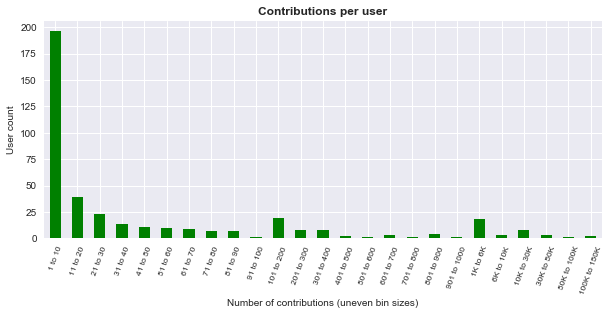

In [35]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

for_plot = df_mode_dict.groupby('bracket')['count'].agg('sum')

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)

#all passengers plot
rects = for_plot.plot(kind='bar',ax=ax,color='g')
ax.set_title('Contributions per user',fontsize='large',fontweight='bold')
ax.set_xlabel('Number of contributions (uneven bin sizes)',fontsize='medium')
ax.set_ylabel('User count',fontsize='medium')
ax.set_xticklabels(for_plot.index.values,rotation='70',fontsize='small')

plt.show()

In [36]:
total_contributions = 0

for doc in grouped_users:
    try:
        total_contributions += int(doc['count'])
    except TypeError:
        pprint(doc)
    


In [37]:
# Looking at top 10 contributors

top_users = list(bergen.aggregate([  
        { "$group" : { 
                "_id" : { "uid": "$created.uid", "username": "$created.user" },"count" : { "$sum" : 1} } },
        { "$sort" : { "count" : -1 } },
         { "$limit" : 10 }
#         { "$project" : { "_id": 0, "user": "$created.user" } } 
    ]))

for doc in top_users:
    print(doc)
    
#Calculating total user contributions for comparison
total_contributions = 0
for doc in grouped_users:
    try:
        total_contributions += int(doc['count'])
    except TypeError:
        pprint('TYPE ERROR:',doc['count'])
print('----')
print('Total contributors:',total_contributions)

total_top_10 = 0
for doc in top_users:
    total_top_10 += doc['count']

top_10_percentage = round((total_top_10/total_contributions)*100,2)

print('Total contributions by top 10 contributors: {0}, {1}%'.format(total_top_10,top_10_percentage))

{'_id': {'uid': '2114448', 'username': 'FredrikLindseth_import'}, 'count': 140794}
{'_id': {'uid': '2836853', 'username': 'frokor_import'}, 'count': 133655}
{'_id': {'uid': '103253', 'username': 'gormur'}, 'count': 80243}
{'_id': {'uid': '992708', 'username': 'Christian Madsen'}, 'count': 39789}
{'_id': {'uid': '722193', 'username': 'daviesp12'}, 'count': 36440}
{'_id': {'uid': '170061', 'username': 'frokor'}, 'count': 31427}
{'_id': {'uid': '1965308', 'username': 'FredrikLindseth'}, 'count': 29969}
{'_id': {'uid': '715936', 'username': 'Gazer75'}, 'count': 22168}
{'_id': {'uid': '3119148', 'username': 'cmeeren_import'}, 'count': 19287}
{'_id': {'uid': '8313', 'username': 'gisle'}, 'count': 16081}
----
Total contributors: 681172
Total contributions by top 10 contributors: 549853, 80.72%


We see here that the large majority of contributions are made by a tiny portion (2.5%) of the contributing users. It seems like a lot of the contributions are automated in some way, as 3 of the top 10 usernames end in "\_import". Any potential contribution patterns these few users have is likely to heavily impact the Bergen OSM data.

According to the address page of the OSM wiki, in mid-2014 all Norwegian official addresses were released to the public. Efforts are being made by OSM volunteers to include the released data in OSM, and the progress is being tracked using a tool called [Beebeetle](http://osm.beebeetle.com/addrnodeimportstatus.php). As of March 4, 2017, the Bergen import is listed as 99.83% complete. 1 known address duplicate is listed on the site.

### Other Features

Before summing up my findings related to addresses, street names and users contributions, I'd like to take a look at the distribution of other features in the dataset.

Since mongodb is schemaless, I'll have to come up with a way to show all available variables. Since documents with types 'node and 'way' are so different from eachother, I will aggregate them separately.

In [73]:
node_features = defaultdict(int)
node_count = 0

for doc in bergen.find({'type': 'node'}):    

    node_count += 1
    for k,v in doc.items():

        try:
            for key,val in v.items():
#             tmp_set.add(k+'_'+key)
                node_features[k+'.'+key] += 1
#         else:
        except AttributeError:
            if type(v) == list:
                for item in v:
                    if type(item) == dict:
                        for key,val in item.items():
                            node_features[k+'.'+key] += 1
                    else:
                        node_features[k] += 1
                
            elif type(v) == str:
                node_features[k] += 1
                    
print("number of node documents:",node_count)
print("Number of node feature types:",len(node_features))

number of node documents: 628779
Number of node feature types: 490


In [74]:
way_count = 0
way_features = defaultdict(int)

for doc in bergen.find( {'type': 'way'}):    

    way_count += 1
    for k,v in doc.items():

        try:
            for key,val in v.items():
#             tmp_set.add(k+'_'+key)
                way_features[k+'.'+key] += 1
#         else:
        except AttributeError:
            if type(v) == list:
                for item in v:
                    if type(item) == dict:
                        for key,val in item.items():
                            way_features[k+'.'+key] += 1
                    else:
                        way_features[k] += 1
                
            elif type(v) == str:
                way_features[k] += 1

print("number of way documents:",way_count)
print("Number of way feature types:",len(way_features))


number of way documents: 52393
Number of way feature types: 358


In [109]:
# #Commented out as it is not needed
# pipeline = [
#     {'$match': {'_type': {'$exists':1 } } },
#     {'$group': {'_id': {'type': '$type', 'feature_type':'$_type'}, 'count': {'$sum': 1 } } },
#     {'$sort': {'count': -1}}
# ]
    
# for doc in bergen.aggregate(pipeline):
#     print(doc)

In [108]:
bergen.find_one({'address.street': {'$exists': 1} })

{'_id': ObjectId('590efcae49fce35f8f53068d'),
 'address': {'city': 'Frekhaug',
  'housenumber': '3',
  'postcode': '5918',
  'street': 'Holtermandsvegen'},
 'amenity': 'school',
 'created': {'changeset': '25431710',
  'timestamp': '2014-09-14T13:03:49Z',
  'uid': '88164',
  'user': 'Med',
  'version': '4'},
 'id': '659034',
 'name': 'Nordhordaland folkehøgskule',
 'operator': 'Nordhordland Indremisjon',
 'pos': [60.514765, 5.2414095],
 'type': 'node',
 'website': 'http://www.skolen.info/',
 'wikipedia': 'no:Nordhordland Folkehøgskule'}

In [42]:
#listing counts of all features in the bergen collection

features = defaultdict(int)

for doc in list(bergen.find()):    

    for k,v in doc.items():
        
        
        try:
            for key,val in v.items():
#             tmp_set.add(k+'_'+key)
                features[k+'.'+key] += 1
#         else:
        except AttributeError:
            if type(v) == list:
                for item in v:
                    if type(item) == dict:
                        for key,val in item.items():
                            features[k+'.'+key] += 1
                    else:
                        features[k] += 1
                
            elif type(v) == str:
                features[k] += 1

In [110]:
#[] NEXT: Find non-numeric values with duplicates in other fields

In [43]:
pprint(features)

defaultdict(<class 'int'>,
            {'FIXME': 30,
             'IATAKODE': 2,
             'ICAOKODE': 2,
             'LUFTHAVNTYPE': 2,
             'TODO': 1,
             '_type': 39,
             'abandoned': 4,
             'abandoned.building': 9,
             'abutters': 91,
             'access': 577,
             'access.conditional': 1,
             'access.lanes': 4,
             'access:lanes:backward': 1,
             'address.city': 84386,
             'address.country': 145,
             'address.floor': 319,
             'address.full': 2,
             'address.housename': 17,
             'address.housenumber': 84377,
             'address.postcode': 84390,
             'address.street': 84441,
             'admin_level': 50,
             'advertising': 6,
             'aerialway': 21,
             'aeroway': 58,
             'alcohol': 1,
             'alt_name': 104,
             'amenity': 3423,
             'amenity.no': 1,
             'amperage': 3,
         

In [44]:
#Listing the features sorted by count

for key in sorted(features,key=features.get,reverse=True):
    print(key,features[key])

pos 1257558
type 681172
created.version 681172
created.changeset 681172
created.user 681172
created.uid 681172
id 681172
created.timestamp 681172
node_refs 636272
address.street 84441
address.postcode 84390
address.city 84386
address.housenumber 84377
highway 27214
source 18457
name 18154
source.date 13311
building 11463
created_by 8539
nvdb.date 6182
nvdb.id 6077
natural 5106
maxspeed 4993
amenity 3423
foot 2301
ref 2065
leaf_type 1987
oneway 1925
surface 1282
barrier 1211
shop 1164
waterway 1006
bicycle 994
layer 969
material 892
website 870
lanes 818
leisure 812
service 778
power 757
operator 719
wheelchair 706
man_made 640
landuse 628
railway 621
crossing 610
access 577
phone 569
backrest 553
public_transport 543
lit 526
sac_scale 511
opening_hours 506
tourism 502
bridge 461
level 458
wetland 417
tunnel 403
note 383
entrance 381
colour 329
address.floor 319
voltage 319
email 318
bus 285
place 280
segregated 272
office 260
int_ref 258
species 245
fixme 235
building.levels 227
sport 

Looking at the counts of features I notice quite a few inconsistencies. For instance, I see multiple instances of website categories.

In [45]:
for key in features:
    if 'url' in key or 'website' in key:
        print(key,features[key])

source.url 10
url 12
contact.website 11
heritage.website 1
website.en 5
website 870
no-kartverket-ssr:url 1


Here at least 'website', and 'url' can probably be merged into one category. It would be beneficial to the data quality if community efforts are made to clean up inconsistent category use.

In [46]:
for key,val in features.items():
    if val < 11:
        print(key,val)

lanes:psv:backward 1
source.url 10
fax 5
outdoor 1
description.no 7
playground.seesaw 1
music_type.en 2
fuel.diesel 5
name.da 2
recycling.chipboard 1
socket:type2:voltage 1
sex 2
local_ref 1
bollard 1
seamark:light:8:range 2
is_in.country_code 1
college 1
drive_through 1
support 6
population.source 1
industrial 1
track_visibility 1
name.no 4
health_facility.type 5
recycling.tyres 1
seamark:radar_transponder:period 1
tidal 1
name.nn 3
ramp.stroller 4
caravans 3
musical_instrument 3
source.highway 4
wifi 2
changing_table 5
crossing.bell 2
sec_level 1
repair 1
swing_gate.type 5
wheelchair.description 9
salt 1
wikipedia.no 1
recycling.batteries 2
depot.type 1
whc.criteria 1
payment.bitcoin 2
monitoring.bicycle 1
note.maxspeed 4
recycling.green_waste 1
taxi 9
seamark:light:1:group 8
cycle 1
natural.no 2
history 4
dispensing 3
wholesale 2
disused 8
access:lanes:backward 1
noexit 9
seamark:light:4:group 6
recycling.light_bulbs 1
canoe_rental 1
vehicle 6
socket.chademo 2
gambling 1
cutting 8
s

### Cuisine and eatery types

In [47]:
#Most common food served at eatiries in Bergen

#Counts of different type of eateries
pipeline = [ 
    {'$match': {'cuisine': { '$exists': 1 } } },
    { '$group': { 
        '_id': {'cuisine': '$cuisine' }, 
        'count': {'$sum': 1 } } 
    },
    { '$sort': {'count': -1 } },
    { '$limit': 10 }
]

print("Cuisine, all eateries")
for doc in bergen.aggregate(pipeline):
    print(doc)


pipeline = [ 
    {'$match': {'amenity': 'restaurant', 'cuisine': {'$exists': 1} } },
    { '$group': { 
        '_id': {'cuisine': '$cuisine' }, 
        'count': {'$sum': 1 } } 
    },
    { '$sort': {'count': -1 } },
    { '$limit': 10 }
]
print('    ')
print("Cuisine, restaurants only")
for doc in bergen.aggregate(pipeline):
    print(doc)

Cuisine, all eateries
{'_id': {'cuisine': 'coffee_shop'}, 'count': 54}
{'_id': {'cuisine': 'burger'}, 'count': 19}
{'_id': {'cuisine': 'pizza'}, 'count': 17}
{'_id': {'cuisine': 'sushi'}, 'count': 14}
{'_id': {'cuisine': 'kebab'}, 'count': 13}
{'_id': {'cuisine': 'chinese'}, 'count': 10}
{'_id': {'cuisine': 'italian'}, 'count': 9}
{'_id': {'cuisine': 'thai'}, 'count': 9}
{'_id': {'cuisine': 'mexican'}, 'count': 6}
{'_id': {'cuisine': 'asian'}, 'count': 5}
    
Cuisine, restaurants only
{'_id': {'cuisine': 'pizza'}, 'count': 14}
{'_id': {'cuisine': 'sushi'}, 'count': 12}
{'_id': {'cuisine': 'chinese'}, 'count': 10}
{'_id': {'cuisine': 'thai'}, 'count': 9}
{'_id': {'cuisine': 'italian'}, 'count': 8}
{'_id': {'cuisine': 'mexican'}, 'count': 6}
{'_id': {'cuisine': 'burger'}, 'count': 4}
{'_id': {'cuisine': 'tapas'}, 'count': 3}
{'_id': {'cuisine': 'persian'}, 'count': 3}
{'_id': {'cuisine': 'indian'}, 'count': 3}


We see here that in Bergen restaurants pizza, sushi and chinese food are the top cuisines. Among all eateries with cuisine information, if we exclude coffee_shop, the top 3 cuisines are burger, pizza and sushi.

In [48]:
#Counts of different type of eateries
pipeline = [ 
    {'$match': {'cuisine': { '$exists': 1 } } },
    { '$group': { 
        '_id': {'eatery_type': '$amenity' }, 
        'count': {'$sum': 1 } } 
    },
    {'$sort': {'count': -1 } }
]

for doc in bergen.aggregate(pipeline):
    print(doc)

{'_id': {'eatery_type': 'restaurant'}, 'count': 94}
{'_id': {'eatery_type': 'cafe'}, 'count': 56}
{'_id': {'eatery_type': 'fast_food'}, 'count': 37}
{'_id': {'eatery_type': None}, 'count': 8}
{'_id': {'eatery_type': 'bar'}, 'count': 1}
{'_id': {'eatery_type': 'pub'}, 'count': 1}
{'_id': {'eatery_type': 'fuel'}, 'count': 1}
{'_id': {'eatery_type': 'marketplace'}, 'count': 1}


The majority of eateries with cuisine information are restaurants, cafés and fast food places.  
Interestingly enough, 8 of the documents with cuisine information are not defined as amenities. I will take a closer look at these documents next.

In [49]:
for doc in bergen.find({'amenity': {'$exists': 0}, 'cuisine': {'$exists': 1} } ):
    pprint(doc)
    print('   ')

{'_id': ObjectId('590efcb349fce35f8f54a892'),
 'address': {'city': 'Bergen',
             'country': 'NO',
             'housenumber': '12',
             'postcode': '5017',
             'street': 'Nedre Korskirkeallmenningen'},
 'created': {'changeset': '37058789',
             'timestamp': '2016-02-07T12:47:26Z',
             'uid': '1965308',
             'user': 'FredrikLindseth',
             'version': '6'},
 'cuisine': 'coffee_shop',
 'email': 'korskirken@godtbrod.no',
 'id': '1388471862',
 'name': 'Godt Brød Korskirken',
 'operator': 'Godt Brød',
 'outdoor_seating': 'yes',
 'pos': [60.3946396, 5.3270844],
 'shop': 'bakery',
 'smoking': 'no',
 'type': 'node',
 'website': 'http://www.godtbrod.no/Bakeverksted/Korskirken'}
   
{'_id': ObjectId('590efcb349fce35f8f54a893'),
 'address': {'city': 'Bergen',
             'floor': '0',
             'housenumber': '19',
             'postcode': '5014',
             'street': 'Vetrlidsallmenningen'},
 'created': {'changeset': '42563970',
  

In [50]:
#Grouping documents above on shop and cuisine
pipeline = [
    { '$match': {'amenity': {'$exists': 0}, 'cuisine': {'$exists': 1} } },
    { '$group': {'_id': {'cuisine': '$cuisine', 'shop type': '$shop'}, 
                'count': {'$sum': 1 } } }
]

for res in bergen.aggregate(pipeline):
    print(res)

{'_id': {'cuisine': 'asian', 'shop type': 'convenience'}, 'count': 1}
{'_id': {'cuisine': 'mediterranean', 'shop type': 'convenience'}, 'count': 1}
{'_id': {'cuisine': 'international', 'shop type': 'convenience'}, 'count': 1}
{'_id': {'cuisine': 'turkish', 'shop type': 'convenience'}, 'count': 1}
{'_id': {'cuisine': 'coffee_shop', 'shop type': 'bakery'}, 'count': 4}


All 8 of these non-eatery documents are considered shops, where 4 are bakeries and 4 are convenience shops.

Last in this section, I will generate counts of restaurants, cafės and fast food restaurants with missing cuisine information.

In [51]:
#Counts of eatery types with cuisine information
pipeline = [ 
    {'$match': {'cuisine':{ '$exists': 1 }, 'amenity': {'$in': ['cafe','restaurant', 'fast_food'] } } },
    { '$group': { 
        '_id': {'eatery_type': '$amenity' }, 
        'count': {'$sum': 1 } } 
    },
    {'$sort': {'count': -1 } }
]

print('Eateries with cuisine information')
for doc in bergen.aggregate(pipeline):
    print(doc)

print('    ')
#Counts of eatery types without cuisine information
pipeline = [ 
    {'$match': {'cuisine':{ '$exists': 0 }, 'amenity': {'$in': ['cafe','restaurant', 'fast_food'] } } },
    { '$group': { 
        '_id': {'eatery_type': '$amenity' }, 
        'count': {'$sum': 1 } } 
    },
    {'$sort': {'count': -1 } }
]

print('Eateries missing cuisine information')
for doc in bergen.aggregate(pipeline):
    print(doc)

Eateries with cuisine information
{'_id': {'eatery_type': 'restaurant'}, 'count': 94}
{'_id': {'eatery_type': 'cafe'}, 'count': 56}
{'_id': {'eatery_type': 'fast_food'}, 'count': 37}
    
Eateries missing cuisine information
{'_id': {'eatery_type': 'restaurant'}, 'count': 95}
{'_id': {'eatery_type': 'cafe'}, 'count': 31}
{'_id': {'eatery_type': 'fast_food'}, 'count': 11}


Quite a few restaurants, cafés, and fast food places lack cuisine information. Community efforts should be made to improve this.

### Final Thoughts

There are 184 address documents without street names in the dataset. Further investigation into those documents is recommended. 

To address the duplicate issue in detail, I suggest following up by looking at the individual duplicate addresses. You could for example start by looking at the three streets with the most individual duplicate addresses to see if there are any useful patterns to be found. Since a few users are very heavy contributors to the Bergen OSM data, it might also be worth searching for user patterns regarding the duplicate addresses.

I would also recommend correcting the misspelled street names, which are stored in data/misspelled_streets.csv, and conduct online research for the street names in data/research_streets_spelling.csv.